## -- 추가 조사 --
이 노트북은 1번 가설에 대해 한국 데이터셋을 적용하여 재분석한 결과입니다. 

연령별 운전자 사고율을 알아보기 위해 전체 면허 소지자에 대한 사고 발생 건수 비율을 계산합니다.

면허 소지자가 운전자 전체 표본으로서 유효한지는 논란이 많이 있을 것으로 보이며, 제대로 된 빈도 수 분석을 위해선 

연령 별 운전자 보험 가입자 수의 데이터가 필요할 것으로 보입니다. 

아쉽게도 해당 데이터는 찾을 수 없었습니다.


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import platform
from sklearn import preprocessing

warnings.filterwarnings('ignore')

# 운영 체제 감지
current_os = platform.system()

# 운영 체제별 폰트 설정
if current_os == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

In [116]:
# 년도별 운전자 보험 가입자 수 데이터 프레임 생성
#df_number_of_real_driver = pd.read_excel(r'./kdata/운전자한정별(개인용).xlsx', engine='openpyxl')
#df_number_of_real_driver.drop(index='자료년도 소계', inplace=True)
#df_number_of_real_driver.drop(columns='자료년도', inplace=True)

In [117]:
# 2017년도 연령별 총 운전자 수 데이터 프레임 생성

df_number_of_driver_17 = pd.read_csv(r'./kdata/경찰청_운전면허소지자(2017년,연령별)현황_20171231.csv', encoding = 'EUC-KR')
df_number_of_driver_17['합계'] = df_number_of_driver_17.loc[:, '1종대형':'원자'].sum(axis=1)
df_number_of_driver_17

# '구분' 칼럼을 정수형으로 변환
df_number_of_driver_17['구분'] = pd.to_numeric(df_number_of_driver_17['구분'], errors='coerce')

# 10세 단위로 연령대 그룹 생성
bins = list(range(10, 100, 10))  # 10세에서 90세까지 10세 단위로 구간 생성
labels = [f'{i}대' for i in range(10, 90, 10)]
df_number_of_driver_17['연령대'] = pd.cut(df_number_of_driver_17['구분'], bins=bins, labels=labels, right=False)

# 연령대 별로 군집화하여 '1종대형'부터 '원자'까지의 합계를 구함
age_group_sum17 = df_number_of_driver_17.groupby('연령대').sum(numeric_only=True).loc[:, '1종대형':'원자']

# 각 연령대에 대한 합계를 계산하여 '합계' 열에 추가
age_group_sum17['합계'] = age_group_sum17.sum(axis=1)

# 2020년도도 마찬가지로 생성

df_number_of_driver20 = pd.read_csv(r'./kdata/경찰청_운전면허소지자 연령별 현황_20201231.csv', encoding='EUC-KR')
df_number_of_driver20['합계'] = df_number_of_driver20.loc[:, '1종대형':'원자'].sum(axis=1)
df_number_of_driver20

# '구분' 칼럼을 정수형으로 변환
df_number_of_driver20['구분'] = pd.to_numeric(df_number_of_driver20['구분'], errors='coerce')

# 10세 단위로 연령대 그룹 생성
bins = list(range(10, 100, 10))  # 10세에서 90세까지 10세 단위로 구간 생성
labels = [f'{i}대' for i in range(10, 90, 10)]
df_number_of_driver20['연령대'] = pd.cut(df_number_of_driver20['구분'], bins=bins, labels=labels, right=False)

# 연령대 별로 군집화하여 '1종대형'부터 '원자'까지의 합계를 구함
age_group_sum20 = df_number_of_driver20.groupby('연령대').sum(numeric_only=True).loc[:, '1종대형':'원자']

# 각 연령대에 대한 합계를 계산하여 '합계' 열에 추가
age_group_sum20['합계'] = age_group_sum20.sum(axis=1)



In [118]:
# 2017, 2020년도 운전자 연령대별 사고 횟수 데이터 프레임 생성
df_accidents_by_age_17 = pd.read_csv(r'./kdata/도로교통공단_가해운전자 연령층별 월별 교통사고(2017).csv', encoding='EUC-KR')
df_accidents_by_age_20 = pd.read_csv(r'./kdata/도로교통공단_가해운전자 연령층별 월별 교통사고(2020).csv', encoding='EUC-KR')

# 월별 데이터를 묶어서 연령 별 총 합계 계산
df_accidents_by_age_17 = df_accidents_by_age_17.groupby('가해자연령층').sum(numeric_only=True)
df_accidents_by_age_20 = df_accidents_by_age_20.groupby('가해자연령층').sum(numeric_only=True)


In [119]:
# 데이터 프레임 간 연산을 이용해 연령 별 사고율을 계산

#전처리 - 인덱스 통일

# 1) 연령별 운전자 수 데이터의 60대 이후를 60대 이상으로 통합
age_group_sum17.loc['60대 이상'] = age_group_sum17.loc['60대':].sum()
age_group_sum17.drop(labels=age_group_sum17.loc['60대':'80대'].index, inplace=True)

age_group_sum20.loc['60대 이상'] = age_group_sum20.loc['60대':].sum()
age_group_sum20.drop(labels=age_group_sum20.loc['60대':'80대'].index, inplace=True)

print(age_group_sum17)
print(age_group_sum20)


          1종대형     1종보통  1종소형  대형견인  소형견인   구난     2종보통  2종소형      원자       합계
연령대                                                                           
10대        779   154679     0     0     0    3   127848   218   19297   302824
20대     164521  2501571     0   103    24  146  2201246  1868   23256  4892735
30대     363530  4070499     0   295   130  211  2243899  1619   15886  6696069
40대     626527  4602857     0   857   153  222  2530305  1496   17902  7780319
50대     666132  3948647     0   878    87  112  2222887  1825   42609  6883177
60대 이상  451198  2573115     9   448    30   35  1859317  2524  215451  5102127
          1종대형     1종보통  1종소형  대형견인  소형견인   구난     2종보통  2종소형      원자       합계
연령대                                                                           
10대        729   140443     0     0     0    2   131718   311   12038   285241
20대     186078  2189215     0   166   110  255  2494727  2840   21012  4894403
30대     333725  3547626     0   283   507  222  2453

In [120]:
# 2) 가해자 연령별 사고 횟수 데이터의 61-64세 데이터와 65세 이상 데이터를 통합, 불명 데이터는 삭제
df_accidents_by_age_17.drop(index='불명', inplace=True)
df_accidents_by_age_17.loc['60대 이상'] = df_accidents_by_age_17.loc['61-64세'] + df_accidents_by_age_17.loc['65세이상']
df_accidents_by_age_17.drop(index=['61-64세', '65세이상'], inplace=True)

idx = ['10대', '20대', '30대', '40대', '50대', '60대 이상']
df_accidents_by_age_17.index = idx

print(df_accidents_by_age_17)

df_accidents_by_age_20.drop(index='불명', inplace=True)
df_accidents_by_age_20.loc['60대 이상'] = df_accidents_by_age_20.loc['61-64세'] + df_accidents_by_age_20.loc['65세이상']
df_accidents_by_age_20.drop(index=['61-64세', '65세이상'], inplace=True)

df_accidents_by_age_20.index = idx

print(df_accidents_by_age_20)

          월   사고건수  사망자수   중상자수   경상자수  부상신고자수
10대      78   8175   124   2743   7114    1561
20대      78  29254   504  10195  32137    3086
30대      78  34179   586  11906  36793    3396
40대      78  43668   739  16310  45579    3901
50대      78  53412  1066  19783  55702    4587
60대 이상  156  43088  1165  16552  42648    3786
        발생월   사고건수  사망자수   중상자수   경상자수  부상신고자수
10대      78   7099   103   2174   6925    1247
20대      78  29775   385   8370  33492    3273
30대      78  31606   383   8887  34949    3086
40대      78  38036   494  10991  41479    3267
50대      78  50421   715  14760  55052    3891
60대 이상  156  49247  1001  14933  51673    3900


# 1. 연령별 교통사고 빈도 및 확률

In [121]:
# 연령대 별 사고율 계산
sr_accident_rate_17 = df_accidents_by_age_17['사고건수'] / age_group_sum17['합계'] * 100
sr_accident_rate_20 = df_accidents_by_age_20['사고건수'] / age_group_sum20['합계'] * 100

sr_accident_rate_17

10대       2.699588
20대       0.597907
30대       0.510434
40대       0.561262
50대       0.775979
60대 이상    0.844511
dtype: float64

In [122]:
sr_accident_rate_20

10대       2.488773
20대       0.608348
30대       0.497630
40대       0.499312
50대       0.683319
60대 이상    0.740600
dtype: float64

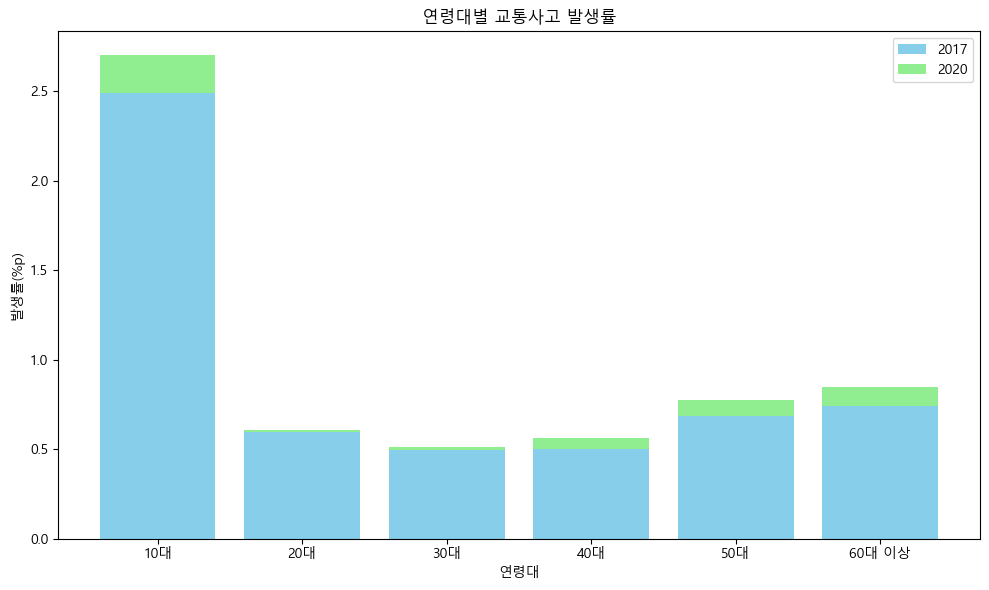

In [133]:
# 데이터프레임으로 변환
df = pd.DataFrame({'2017': sr_accident_rate_17, '2020': sr_accident_rate_20})

df['Min'] = df.min(axis=1)
df['Max'] = df.max(axis=1)

# 막대 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 작은 값을 먼저 그리기
ax.bar(df.index, df['Min'], label='Min', color='skyblue')

# 큰 값을 그리기 (작은 값을 기준으로 쌓기)
ax.bar(df.index, df['Max'] - df['Min'], bottom=df['Min'], label='Max', color='lightgreen')

# 제목과 축 라벨 추가
plt.title('연령대별 교통사고 발생률')
plt.xlabel('연령대')
plt.ylabel('발생률(%p)')

# 범례 추가
plt.legend(['2017', '2020'])

# 그래프 표시
plt.tight_layout()
plt.show()
